This notebook is from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Stacked Regressions


In [0]:
# 필요한 라이브러리 Import

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args,**kwargs):
  pass
warnings.warn = ignore_warn # 경고 발생시 무시

from scipy import stats
from scipy.stats import norm, skew # 수치해석 기능(확률분포) 제공

In [0]:
# Pandas DataFrame 불러오기
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/home-data-for-ml-course/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/home-data-for-ml-course/test.csv')

In [145]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [146]:
test.head(5) # 5x80

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [147]:
# 데이터 Shape 확인
print("The train data size before dropping ID feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# 'Id'컬럼 저장하기
train_ID = train['Id']
test_ID = test['Id']

# 필요없는 Id 컬럼, Drop하자.
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

# 'Id'를 제거한 DataFrame의 Shape 확인
print("The train data size after dropping ID feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping ID feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 
The train data size after dropping ID feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


## Data Processing

### Outliers

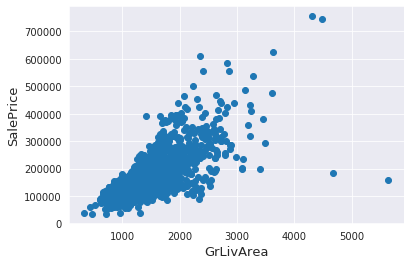

In [148]:
fig,ax = plt.subplots()
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()

산포도를 확인해보면 오른쪽 하단 부분에 낮은 SalePrice를 나타내는 두개의 GrLivArea가 있음. 

**이것들은 상당히 큰 이상치이므로 삭제를 해야한다.**

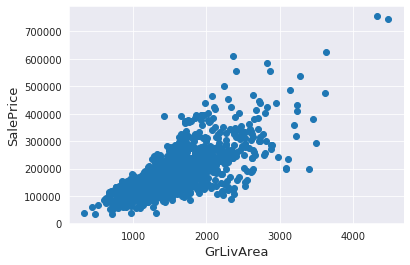

In [149]:
# 이상치 삭제
train = train.drop(train[(train['GrLivArea']>4000)& (train['SalePrice']<300000)].index) # '.index' :'axis=0'

# 다시 확인
fig,ax = plt.subplots()
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()

**참고:**

이상치 제거는 항상 안전한 것은 아님. 여기서도 상당히 극단적인 두개의 값만 제거함.

다른 이상치들도 Train data에 존재한다. 하지만, Test 데이터에도 이상치가 있다면 이상치 모두를 제거하는 것은 모델들에게 상당히 안좋은 영향을 끼친다. 그렇기 때문에, 이상치를 모두 제거하는 대신에 몇몇 모델을 강화할 것이다.

### Target Variable
- **SalePrice**는 우리가 예측해야할 종속변수이다.

scipy 확률분포 객체
- 이산:	bernoulli	베르누이 분포
- 이산:	binom	이항 분포
- 연속:	uniform	균일 분포
- 연속:	norm	가우시안 정규 분포
- 연속:	beta	베타 분포
- 연속:	gamma	감마 분포
- 연속:	t	스튜던트 t 분포
- 연속:	chi2	카이 제곱 분포
- 연속:	f	F 분포
- 연속:	dirichlet	디리클리 분포
- 연속:	multivariate_normal	다변수 가우시안 정규 분포

확률분포 메서드
- pdf	확률 밀도 함수 (probability density function)
- pmf	확률 질량 함수 (probability mass function)
- cdf	누적 분포 함수 (cumulative distribution function)
- rvs	랜덤 샘플 생성 (random variable sampling)
- stats	기술 통계 함수 (descriptive statistics)
- fit	모수 추정 (parameter estimation)


 평균 = 180932.92 and 표준편차 = 79467.79



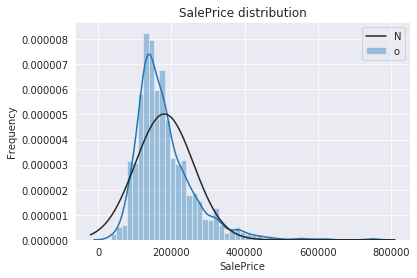

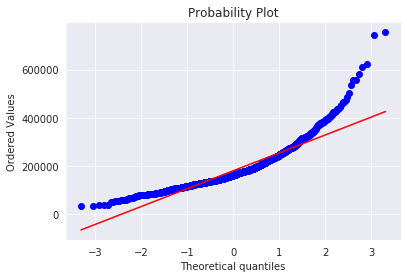

In [150]:
sns.distplot(train['SalePrice'], fit=norm); # fit=norm : 그래프에 정규분포 반환

# 함수에 사용될 적합한 매개변수 가져오기 
(mu,sigma) = norm.fit(train['SalePrice']) # 모수추정(평균,표준편차)
print( '\n 평균 = {:.2f} and 표준편차 = {:.2f}\n'.format(mu, sigma))

# 분포 구성(plot)
plt.legend('Normal dist.($\mu=${:.2f} and $\sigma=${:.2f} )'.format(mu,sigma))
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
# 분석하고자 하는 샘플의 분포와 정규 분포의 분포 형태를 비교하는 시각적 도구
# Q-Q 정보만을 반환하고 챠트는 그리지 않는다. plot=plt를 해야함. (2)
# 정규 분포를 따르는 데이터 샘플을 Q-Q 플롯으로 그리면 다음과 같이 직선의 형태로 나타난다. (그래프)
fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot=plt)
plt.show()

종속변수가 오른쪽으로 치우쳐 있음. 선형 모델들에는 정규분포 데이터가 적합하기 때문에 변수를 변환하고, 더 정상적으로 분포되게 만들어야 한다.

***종속 변수의 로그변환***
- np.log(x), np.log10(x), np.log2(x), log1p(z)
- log함수는 0에 가까워 질수록 마이너스 무한대로 감. (에러발생, 변환x)
  - 이를 해결하기 위해 x축에 1을 더하여(그래프를 x축으로 -1 만큼 평행이동) 시작값을 0부터 시작하게 처리함.
![대체 텍스트](https://i.stack.imgur.com/ycPOC.png)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


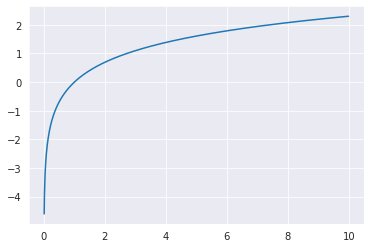

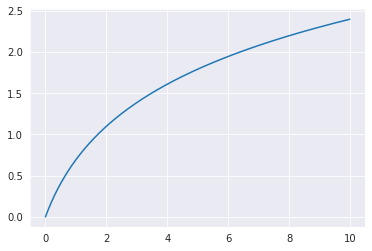

In [151]:
#로그함수 예시
x = np.arange(0,10.0,0.01)
y= np.log(x)
fig1 = plt.figure()
plt.plot(x,y)
fig2 = plt.figure()
y= np.log(x+1)
plt.plot(x,y)
plt.show()


 평균 = 12.02 and 표준편차 = 0.40



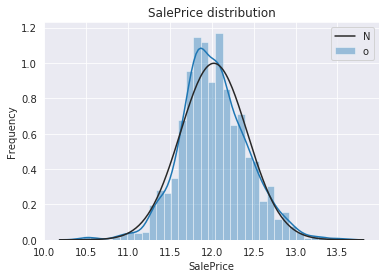

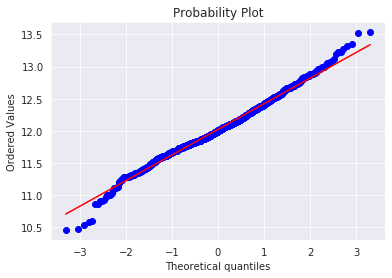

In [152]:
# numpy의 log1p 적용
train['SalePrice'] = np.log1p(train['SalePrice'])

# 로그변환한 분포 확인
sns.distplot(train['SalePrice'],fit=norm);

(mu,sigma) = norm.fit(train['SalePrice']) # 모수추정(평균,표준편차)
print( '\n 평균 = {:.2f} and 표준편차 = {:.2f}\n'.format(mu, sigma))

plt.legend('Normal dist.($\mu=${:.2f} and $\sigma=${:.2f} )'.format(mu,sigma))
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot=plt)
plt.show()

데이터가 정상적으로 분포하는 것으로 나타남.

### Feature Engineering

train 데이터와 test데이터를 하나의 데이터프레임으로 합치자.
- pd.concat( default: axis=0)
- reset_index(default: drop=False) : False: 원래의 인덱스로 반환, True: 새롭게 인덱스 적용

In [153]:
ntrain = train.shape[0] # 행 개수 반환
ntest = test.shape[0] # 행 개수 반환
y_train = train.SalePrice.values # array로 SalePrice 반환
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace=True)
print('all_data의 크키는 : {}'.format(all_data.shape))

all_data의 크키는 : (2917, 79)


#### Missing Data

In [154]:
all_data_na = (all_data.isnull().sum()/len(all_data))* 100 # 비율로 표현하기 위해
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

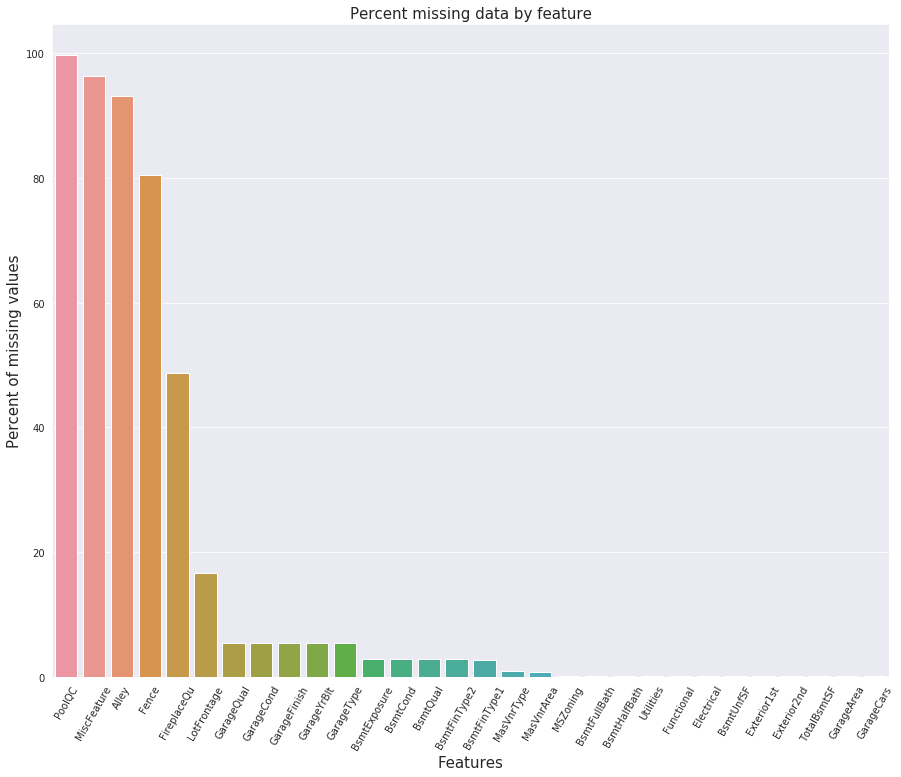

In [155]:
f,ax = plt.subplots(figsize = (15,12))
plt.xticks(rotation='60') # 변수 이름끼리 겹치지 않게 글자를 회전시켜줌. 
sns.barplot(x=all_data_na.index,y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

##### Data Correlation
- sns.heatmap()
  - cbar : 오른쪽 막대 표현 여부
  - vmax : 색깔 농도의 최대치
  - square는 정사각형으로 지정하는 것이며, False로 설정 시 직사각형
  - cmap : 색깔 지정

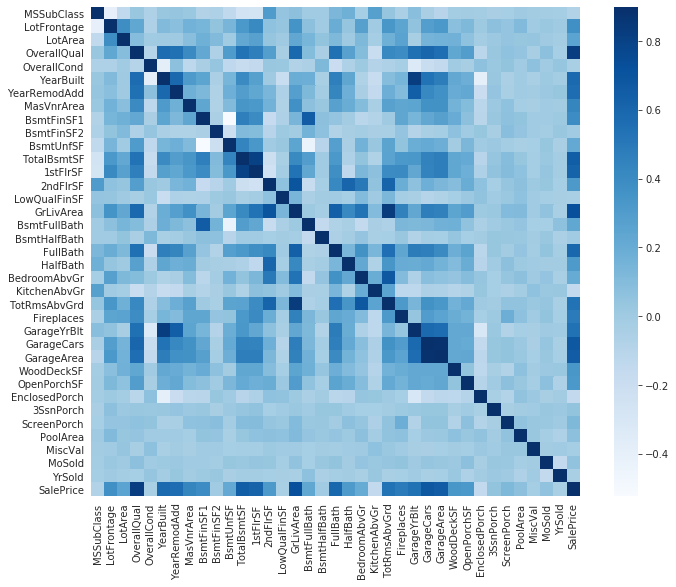

In [156]:
# 독립변수들와 SalePrice의 상관관계
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,cbar=True,vmax=0.9,square=True,cmap='Blues')

##### Imputing missing values
순차적으로 missing values를 없애자. NA라고 모두 값이 없음(존재하지 않음)으로 받아 들이면 안된다. 단순하게 없는 것일 수도 있음. 의미를 잘 파악해야함.

ex) 차고의 개수에서 NA라고 단순히 결측치로 받아 들이는 것보다는 차고가 없는 것을 뜻하는 지도 확인해 봐야한다.

- PoolQC: 데이터 설명서를 보면 NA는 'No Pool'을 의미한다. 즉, 99%의 결측치, 대부분의 집이 Pool이 없다고 여기면 된다.

In [0]:
all_data['PoolQC']= all_data['PoolQC'].fillna('None')

- MiscFeature: NA는 No MiscFreature

In [0]:
all_data['MiscFeature']= all_data['MiscFeature'].fillna('None')

- Alley: NAsms 'No alley access'를 의미 

In [0]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- Fence: NA = No Fence

In [0]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- FireplaceQu : NA = No Fireplace

In [0]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- LotFrontage: 집과 연결된 거리의 넓이는 이웃집과 비슷하게 형성되기 때문에, 이웃집을 기준으로 중앙값으로 NA를 처리하도록 하자.
 - MSZoning으로 구분지어도 괜찮을 것 같음.


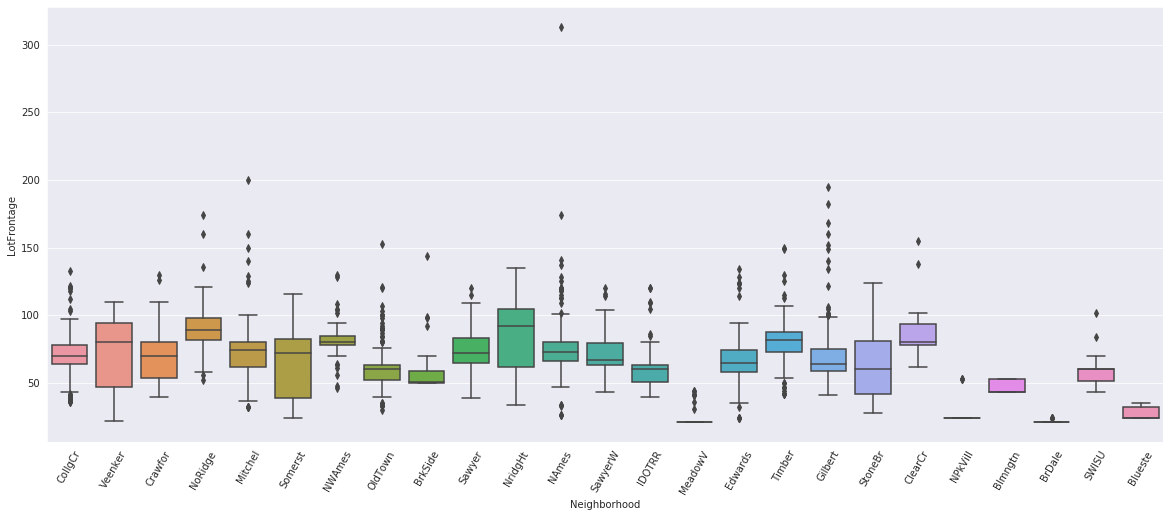

In [162]:
plt.figure(figsize=(20,8),facecolor='w')
plt.grid(True)

sns.boxplot(x="Neighborhood",y='LotFrontage',data=all_data)
#sns.swarmplot(x="Neighborhood",y='LotFrontage',data=all_data,color='.25')
plt.xticks(rotation='60')
plt.show()

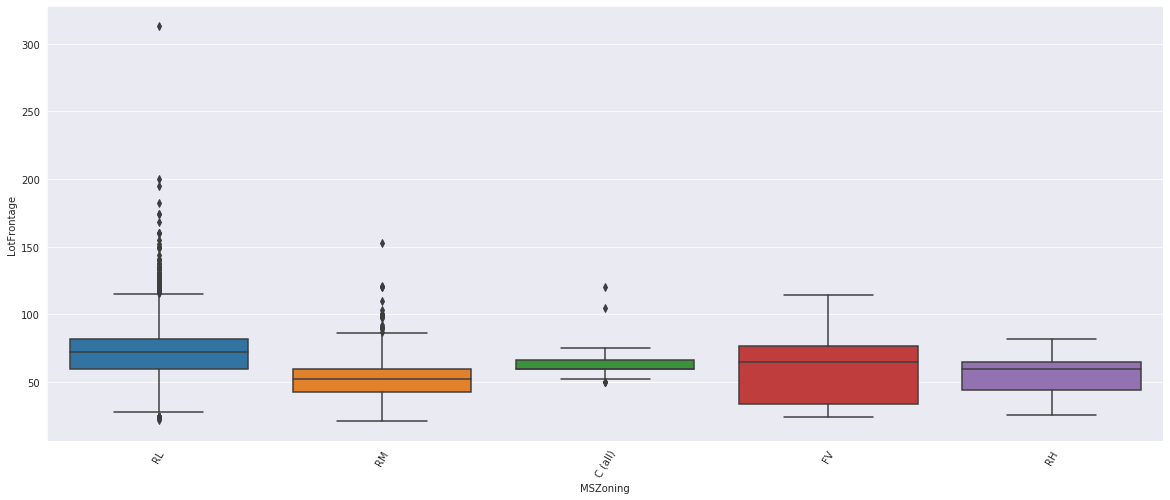

In [163]:
plt.figure(figsize=(20,8),facecolor='w')
plt.grid(True)

sns.boxplot(x="MSZoning",y='LotFrontage',data=all_data)
#sns.swarmplot(x="Neighborhood",y='LotFrontage',data=all_data,color='.25')
plt.xticks(rotation='60')
plt.show()

In [164]:
all_data['LotFrontage'] = all_data.groupby("Neighborhood")['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

'''
all_data['LotFrontage'].fillna(
    all_data.groupby("Neighborhood")['LotFrontage'].transform('median'),inplace=True)
'''

# all_data.groupby(["Neighborhood",'MSZoning'])['LotFrontage'].median() 로 하면 어떨까

'\nall_data[\'LotFrontage\'].fillna(\n    all_data.groupby("Neighborhood")[\'LotFrontage\'].transform(\'median\'),inplace=True)\n'

- GarageType, GarageFinish, GarageQual and GarageCond : Missing Value를 None으로 바꾸자

In [0]:
for col in ('GarageType', 'GarageFinish', 'GarageQual','GarageCond'):
  all_data[col]= all_data[col].fillna('None')

- GarageYrBlt, GarageArea and GarageCars: Missing value를 0으로 처리하자.

In [0]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : Missing value는 'No basement'에 대한 0을 나타냄

In [0]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
            'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2: Basement와 관련된 범주형 변수들임. NaN의 뜻은 'No Basement'를 뜻함.

In [0]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- MasVnrArea and MasVnrType: NA 값은 masonry veneer가 없는 것으로 의미 0 과 None으로 채우면 됨.

In [169]:
all_data[all_data['MasVnrArea']==0][['MasVnrArea', 'MasVnrType']]

,MasVnrArea,MasVnrType
1,0.0,None
3,0.0,None
5,0.0,None
8,0.0,None
9,0.0,None
...,...,...
2911,0.0,None
2912,0.0,None
2913,0.0,None
2914,0.0,None


In [170]:
all_data[all_data['MasVnrArea'].isna()==True][['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,NaN
528,NaN,NaN
649,NaN,NaN
935,NaN,NaN
972,NaN,NaN
976,NaN,NaN
1242,NaN,NaN
1277,NaN,NaN
1689,NaN,NaN
1704,NaN,NaN


In [0]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- MSZoning (The general zoning classification): RL 값이 제일 많으므로 NA값을 RL로 넣자.

In [0]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
# all_data['MSZoning'].mode()[0] ='RL'

- Utilities
 - 1개의 NoSewa와 2개의 NA
 - NoSeWa는 traindata에만 있어 이러한 컬럼은 예측모델링에 도움이 되지 않기 때문에 지워주는 것이 나음.

In [173]:
all_data['Utilities'].value_counts() 

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [174]:
all_data[all_data['Utilities']=='NoSeWa'].index[0]

943

In [0]:
all_data = all_data.drop(['Utilities'],axis=1)

- Functional: deductions가 보장되어 있지 않으면 'typical'로 가정하라고 나와 있음.

In [0]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- Electrical
 - 1개의 Missing value
 - 제일 많은 것으로 처리

In [0]:
all_data['Electrical'] = all_data['Electrical'].fillna(
    all_data['Electrical'].mode()[0])

- KitchenQual
 - 1개의 Missing value
 - 제일 많은 것으로 처리

In [0]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(
    all_data['KitchenQual'].mode()[0])

- Exterior1st and Exterior2nd (옥외덥개)
 - 각각 1개의 missing value
 - 제일 많은 것으로 처리

In [0]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(
    all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(
    all_data['Exterior2nd'].mode()[0])

- SaleType : 가장 많은 값으로 처리

In [0]:
all_data['SaleType'] = all_data['SaleType'].fillna(
    all_data['SaleType'].mode()[0])

- MSSubClass: 흠.. NA값이 건축 클래스가 지정이 안된 것을 의미한다고 하는데 설명서에는 따로 기재가 되어 있지는 않음.

In [0]:
all_data['MSSubClass']= all_data['MSSubClass'].fillna('None')

Missing Value가 더 있는지 확인해 보자.

In [182]:
# 남아있는 결측치(Missing Value 확인)
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head()

,Missing Ratio


결측치 無

#### More feature engeneering

범주형인 숫자의 변수를 처리하자

In [0]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#OverallCond
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

순차적 범주형 볌수는 labelencoding을 적용하자

In [184]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


집값에 근본적으로 영향을 끼치는 것이 뭘까? 바로 '평수(넓이)'이다. 그렇기 떄문에, 창고, 1층,2층의 넓이를 모두 합치는 것이 좋다.

In [0]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#####Skewed features
- 연속형 변수들 중에 정규분포를 따르지 않는 것(왜도 확인)
- skew()함수 사용

In [186]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
print(skew(all_data[numeric_feats]))

# 숫자형 변수중에 치우침을 확인해 보자.
skewed_feats = all_data[numeric_feats].apply(
    lambda x: 
    skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

[  1.25728598   0.86155552  11.37207993  -0.65170527   0.32656827
  -2.86127142  -1.11732123   0.98064459   4.14450336   0.08364123
  -3.04297932   0.62241476   3.92999597  -0.48836241   0.91968821
  -3.45755483   4.00234409  -2.49648923  -1.80006232  -1.99264928
   0.33261087   0.72527792   0.16551426  -4.05412621   0.21685689
  -0.21929723  -3.59428981  -0.60995323  -3.07278781  -3.90463233
   1.06875039   0.69666596   0.4855343    4.30055011  -1.4498143
   4.97325361  13.10949469   1.1030386   -0.61856361  12.0845388
   0.13970903   2.6217193   21.93967217  -0.64617306   2.5293582
   0.56931382   0.18959089  -2.97774105  17.68866449 -21.2175999
   3.94510123 -15.49475602   0.74923209   0.6717514    1.84479163
  -0.59919436  -0.45013375   0.13199576   1.00915662]

Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


**Box Cox Tranformation of (highly) skewed freatures**
- 비정상 확률 과정을 정상 확률 과정으로 변환하는 방법
 1. 차분
 2. 백분율(percentage change) 혹은 로그(logarithm) 변환
 3. Box-Cox 변환


scipy의 1+x의 Box-Cox 변환을 계산하는 boxcox1p를 사용

- 위에서 종속변수에 적용한 log1p와 같은 원리이다.


In [187]:
skewness = skewness[abs(skewness) > 0.75] #abs:절대값
print("Box-Cox로 변형해야할 변수들이 {}개 있다. ".format(skewness.shape[0]))

Box-Cox로 변형해야할 변수들이 59개 있다. 


In [0]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
  #all_data[feat] += 1
  all_data[feat] = boxcox1p(all_data[feat],lam)

#all_data[skewed_features] = np.log1p(all_data[skewed_features])

##### Getting dummy categorical features

In [189]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


## Getting the new train and test sets.



In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modelling

Import libraries

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Define a cross validation strategy


교차검증반복
- cross_val_score(
  - model=모델,
  - x=독립변수,
  - y=종속변수,
  - scoring=성능 검증에 사용할 함수 이름,
  - cv=교차검증 생성기 객체 또는 숫자)
- cross_val_score에는 shuffle기능이 없기 때문에 shuffle을 할 수 있는 KFold 코드를 추가

참조
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [0]:
# Validation function
n_folds =5
def rmsle_cv(model):
  kf = KFold(n_splits = n_folds,shuffle=True,random_state=42).get_n_splits(train.values)
  # kf = 5
  rmse = np.sqrt(-cross_val_score(model,train.values,y_train,scoring=
                                  'neg_mean_squared_error',cv=kf))
  return(rmse)

### Base models

- LASSO Regression:

이 모델은 아웃라이어에 민감하다. 그렇기 떄문에 아웃라이어에 robust(튼튼)하게 만들어야함. 

-> 파이프라인에 Robustscaler() 적용


In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- Elastic Net Regression

 For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.


 참조 https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [0]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005,
                                                l1_ratio=.9, random_state=3))

- Kernel Ridge Regression 

In [0]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- Gradient Boosting Regression

In [0]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- XGBoost

In [0]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

- LightGBM 

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#### Base models scores

In [199]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [200]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [201]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [202]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



In [203]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1168 (0.0058)



In [204]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1167 (0.0072)



### Stacking models

#### Simple Stacking approach : Averaging base models

Averaged base models class

In [0]:
class AveragingModels(BaseEstimator,RegressorMixin,TransformerMixin):
  def __init__(self,models):
    self.models = models
  
  # 데이터에 맞는 원래의 모델의 Clones을 정의
  def fit(self,X,y):
    self.models_ = [clone(x) for x in self.models]

    # Train cloned base models
    for model in self.models_:
      model.fit(X,y)
    
    return self

  # 복제된 모델들에 대한 예측과 평균을 낸다.
  def predict(self, X):
    predictions = np.column_stack([model.predict(X) for model in self.models_])
    return np.mean(predictions,axis=1)

Averaged base models score

- 다른 모델들도 더 추가할 수 있음

In [206]:
averaged_models = AveragingModels(models=(ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1091 (0.0075)



#### Less simple Stacking : Adding a Meta-mode

In [0]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Stacking Averaged models Score

In [209]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1085 (0.0074)


Stacking Models을 적용하면 Score가 개선된 것을 볼 수 있음.

---

최종적으로 Training을 하고 Prediction을 할때 StackingRegressor와 Xgboost,Lightgbm과 함께 앙상블 예측을 적용하는 것이 좋음.


    def rmsle(y, y_pred):
       return np.sqrt(mean_squared_error(y, y_pred))